# Calibration Exercice

This exercise is about calibration, that is to make a certain type of method or measurement more precise by taking into account effects that otherwise blurs the precision of the method by correcting for these effects. The below example is constructed, but outlines the considerations.

**Calibration play a role in essentially all physics measurements, in the eternal competition for precision.**

## Description
  You're developping a new method for measuring the distance to stars, and want to
  calibrate and thus improve this method, such that the precision obtained is unbiased
  and has a minimal variance. You know that the method could depend on several factors, such as:
   * Amount of signal light from the star `lsig`
   * Amount of background light in the surrounding sky `lbkg`
   * Temperature of star `temp`
   * Transparency of sky `tsky`

In order to determine the influence of these factors, and how you need to correct for each of them, you consider 10.000 stars with known distances (measured by another method, e.g. triangulation). From these, you can find out how well your own method works, make corrections to biases as needed, and finally find out how precise your calibrated method is.

Your calibration technique should be able to do the following:
   * Correct the offset from zero
   * Reduce the RMS of the (residual) distribution
   * Mitigate the tail at high (residual) values
    

## Your Task

* As always look at the data and get a feel for each of the variables. A good idea might be to plot them all to know what range to expect them in.

* Then, consider the raw distribution of "relative differences" ($R_D$) between the observed and actual distance: $R_{D} = \frac{(D_{obs} - D_{known})}{D_{known}}$. You'll notice that this distribution is far from an ideal (and narrow) gaussian, which is why you'll need to calibrate your method using the underlying data.

* Go on and look at the distribution of the bias of the relative difference as a function of the data variables (i.e. 2D histograms). Try to identify variables that are correlated with the relative differences, extract (that is fit) for the size of the effect, and apply a correction factor to eliminate these biases.

Note that if you are on average say 50% too high compared to the true values, then you need to correct by 50%, i.e. divide by (1 + 0.5), and in general, if your measurement is $f(x)$ off, where $f(x)$ describes the offset, then you need to divide by $(1 + f(x))$:

$R_{D} = \frac{d - d_{true}}{d_{true}}  \rightarrow  d_{calib} = \frac{d}{(1 + f(x))}$

Thus, define `d_calib = d / (1 + f(x))`, and continue using `d_calib` when considering other effects.

<p style="text-align: center;"><b>Happy calibration!</b><p>


##  Author:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

##  Date:
12th of December 2023

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

In [4]:
verbose = True
Nverbose = 10
SaveFigures = False

### Define profile function (2D histogram to 1D plot):

Profile x of the two arrays x and y with defined number of bins and range returns the x-values of the profile, the means and the standard deviations.

This enables you to fit a trend in a 2D histogram (which shows any variation of your key variable of interest with other variables) with a 1D function, and thus currect of the possible effect of this other variable.

In [5]:
def profile_x(x, y, bins=(50, 50), xyrange=[(0, 50), (-1,1)]):
    
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=xyrange)
    x_center = 0.5*(xedges[1:] + xedges[:-1])
    y_center = 0.5*(yedges[1:] + yedges[:-1])
    
    wsums = H.sum(1)
    
    mask = wsums > 0
    
    mean = (H*y_center).sum(1)[mask] / wsums[mask]
    mean_squared = (H*y_center**2).sum(1)[mask] / wsums[mask]
    std = np.sqrt( mean_squared - mean**2 ) / np.sqrt(wsums[mask]) 

    return x_center[mask], mean, std

## Reading the data file:

There are multiple ways we can retrieve the information from a text file, but here we use the `loadtxt` function of the `numpy` package. This is a very powerful function that allows you to parse an entire textfile in a single line, _provided that the text file is formatted properly_. For more advanced parsing option, you can also check out `numpy.genfromtxt`.

In [6]:
filename = "data_calib.txt"
dknown, dmeas, lsig, lbkg, temp, tsky = np.loadtxt(filename, unpack=True)

In [7]:
# Check that this worked:
if (verbose) :
    for i in range(Nverbose) :
        print("  Distance (known) = {:8.2f}    Distance (measured) = {:6.3f} ".format(dknown[i], dmeas[i]))
print("The TOTAL number of entries read is: ", len(dmeas))

  Distance (known) =  9209.51    Distance (measured) = 5820.208 
  Distance (known) =   149.38    Distance (measured) = 174.093 
  Distance (known) =   412.18    Distance (measured) = 423.608 
  Distance (known) =   119.81    Distance (measured) = 126.137 
  Distance (known) =   175.10    Distance (measured) = 250.720 
  Distance (known) =   146.20    Distance (measured) = 227.391 
  Distance (known) =   324.05    Distance (measured) = 422.474 
  Distance (known) =   256.97    Distance (measured) = 229.279 
  Distance (known) =   175.40    Distance (measured) = 156.558 
  Distance (known) =   353.27    Distance (measured) = 353.121 
The TOTAL number of entries read is:  10000


## Look at data:

As always, it is a good idea to take a quick look at the data. First the input variables, but also what the "raw" (i.e. before calibration) performance of the method is.

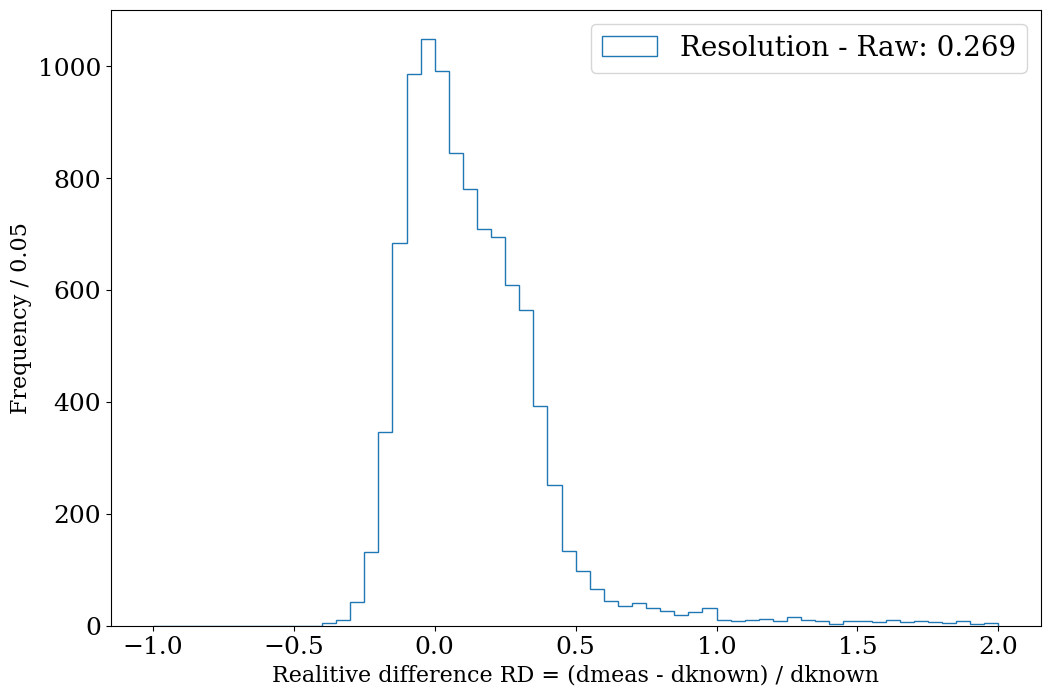

In [8]:
# We calculate the relative difference RD, between the estimated and the known distance:
RD = (dmeas - dknown) / dknown
Res_Raw = np.std(RD[(-2.0 < RD) & (RD < 2.0)])    # Resolution masking out outliers

# ... and then plot it:
xminRD, xmaxRD = -1.0, 2.0 
NbinsRD = 60
fig_RD, ax_RD = plt.subplots(figsize=(12,8))
ax_RD.hist(RD, bins=NbinsRD, range=(xminRD,xmaxRD), histtype='step', label=f'Resolution - Raw: {Res_Raw:5.3f}')
ax_RD.set_xlabel('Realitive difference RD = (dmeas - dknown) / dknown', fontsize=16)
ax_RD.set_ylabel('Frequency / 0.05', fontsize=16)
ax_RD.legend(fontsize=20);

if (SaveFigures):
    fig_rel.savefig('Resolution_Uncalibrated.pdf', dpi=600)

## Consider (cor)relations between variable and method performance:

The way to investigate, if there is a (cor)relation between the target (distance in terms of RD) and any of the factors/variables/auxiliary observables, is to plot them against each other in 2D histograms. If there are any visible relation, then this is an effect of the ourside factors (lsig, lbkg, temp, and tsky) on the wanted observable (distance), which we want to correct for.

In the following, we produce this 2D histogram along with a 1D graph on top showing the mean and uncertainty for each bin in x (the x "profile"). This graph shows any possible (average) relation in a way, which can then be fitted.

Lsig calibration fit result:
Fit value: p0 = 0.16009 +/- 0.00632
Fit value: p1 = -0.00110 +/- 0.00021


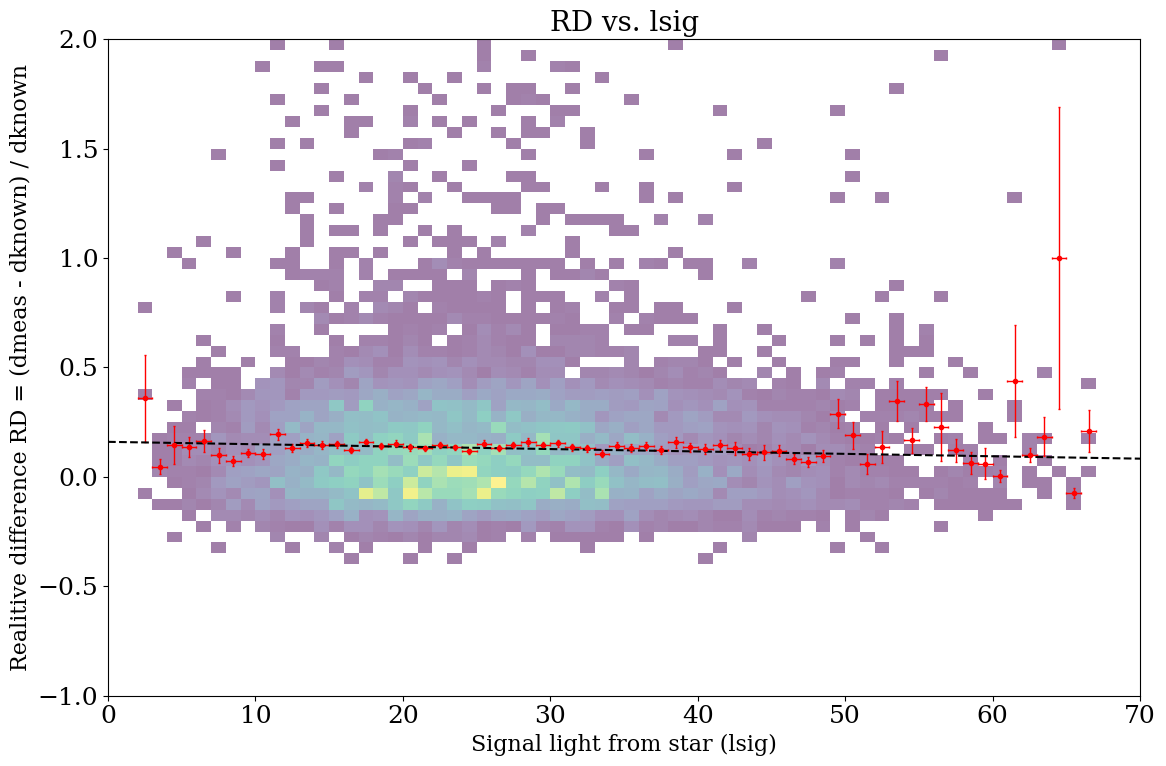

In [9]:
# Thus we plot RD as a function of "lsig" to see, if there is any strange effects:
fig_lsig2D, ax_lsig2D = plt.subplots(figsize=(12,8))
ax_lsig2D.hist2d(lsig, RD, bins=(70,60), range=[(0, 70), (-1,2)], cmin=1, alpha=0.5)
ax_lsig2D.set_title('RD vs. lsig', fontsize=20);
ax_lsig2D.set_xlabel('Signal light from star (lsig)', fontsize=16)
ax_lsig2D.set_ylabel('Realitive difference RD = (dmeas - dknown) / dknown', fontsize=16)

# 1D "profile" of the histogram to better see (and fit) any variation in RD with lsig:
x_center_lsig2D, mean_lsig2D, std_lsig2D = profile_x(lsig, RD, bins=(70, 60), xyrange=[(0, 70), (-1,2)])
x_binwidth_lsig2D = x_center_lsig2D[1] - x_center_lsig2D[0]
ax_lsig2D.errorbar(x_center_lsig2D, mean_lsig2D, xerr=x_binwidth_lsig2D/2, yerr=std_lsig2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1)

# Fit for the effect from "lsig" on RD in the 1D graph:
def lsig_calibfit(x, p0, p1):
    return p0 + p1*x

chi2_object_lsig = Chi2Regression(lsig_calibfit, x_center_lsig2D, mean_lsig2D, std_lsig2D)
minuit_lsig = Minuit(chi2_object_lsig, p0=0.0, p1=0.0)
minuit_lsig.errordef = 1.0
minuit_lsig.migrad()

# Print fit result:
print("Lsig calibration fit result:")
for name in minuit_lsig.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_lsig.values[name], minuit_lsig.errors[name]))

# Draw the fit on top of the plot along with numbers for quantification:
x_fit = np.linspace(0, 70, 1000)
y_fit_lsig = lsig_calibfit(x_fit, *minuit_lsig.values[:])
ax_lsig2D.plot(x_fit, y_fit_lsig, '--k')
fig_lsig2D.tight_layout()

## Calibrating for "lsig" based on 2D plot:

Well, as it seems, $R_D$ does not depend heavily on lsig. However, in the following, I'm still going to test this, and use the result to correct for and thus calibrate $R_D$. Then you will have to do this for the other variables.

In [10]:
# Apply calibration as found from the 2D plot below:
dmeas_calib_lsig = dmeas / (1.0 + lsig_calibfit(lsig, *minuit_lsig.values[:]))

# Once you have made the calibration, the (improved?) relative resolution becomes:
RD_calib_lsig = (dmeas_calib_lsig - dknown) / dknown

# Determine the new calibrated resolution (quantified as the RMSE) before and after the calibration:
Res_calib_lsig = np.std(RD_calib_lsig[(-2.0 < RD_calib_lsig) & (RD_calib_lsig < 2.0)])    # Resolution masking out outliers
print(f"  The initial and final resolutions are:  {Res_Raw:6.3f}  and  {Res_calib_lsig:6.3f} \n")

  The initial and final resolutions are:   0.269  and   0.261 



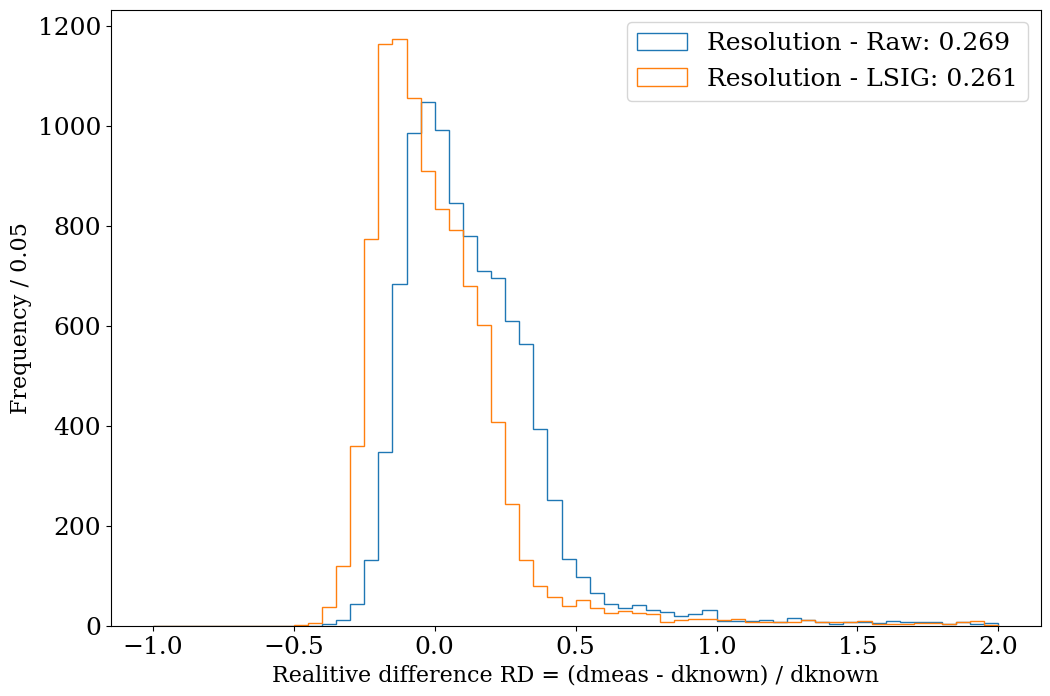

In [11]:
# Re-draw the resolution plot:
ax_RD.hist(RD_calib_lsig, bins=NbinsRD, range=(xminRD,xmaxRD), histtype='step', label=f'Resolution - LSIG: {Res_calib_lsig:5.3f}')
ax_RD.legend()
fig_RD

## Comments on process:

The first step of the calibration didn't improve anything much (it was designed not to!), except moving the mean of $R_D$ to zero, such that the estimates of your new fancy method at least were not biased. The Standard Deviation remains around 0.26, i.e. a 26% precision, and the resolution is not very Gaussian either, which is not what you hoped for. **This is what you want to improve upon!**

The way forward is to consider other effects (i.e. the other variables) and correct for possible effects from these. Note that once you have calibrated for one effect/variable, **you should continue with the calibrated version of the relative difference RD**, as there might be a correlation between the effects. In the end, your calibrated measurement can (and will) be the result of several consecutive corrections (thus the order might matter slightly, though this is a secondary effect).
 
Also note, that even if the function you find for correcting isn't perfect, it is surely still better, than doing nothing, and so it should be applied anyhow.

## Questions:

1. Which of the four variables (lsig, lbkg, temp, and tsky) causes the long tail towards high values in $R_D$?
2. Try to rank the four variables according to importance (think about what that means).
3. Do you think that the order of the calibration makes a difference? If so, should one start or end with the most important variables?
4. Just how good a resolution can you get? Share it with the class...

# Learning points:

From this exercise you should
1. Generally, understand the concept of calibration<br>
   (i.e. correcting your data for effects that you can measure/determine by some mean).
2. Be able to apply a calibration to data<br>
   (i.e. measure/determine the size of an effect, and correct data accordingly).
3. Have an idea of what to think of **ahead** of an experiment to ensure good calibration<br>
   (i.e. go through the list of needed measurements and think about how to ensure their precision).